# Beispiel 11.4: Sensitivität eines Rohrreaktors
Bearbeitet von Franz Braun

Dieses Beispiel befindet sich im Lehrbuch auf den Seiten 153 - 154. Die Nummerierung
der verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch. Das hier angewendete
Vorgehen entspricht dem im Lehrbuch vorgestellten Lösungsweg.

Zunächst werden die benötigten Pakete importiert.

In [1]:
### Import
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tabulate import tabulate

Dieses Beispiel illustriert die parametrische Sensitivität eines stationär betriebenen Rohrreaktors.
Es werden die Zahlenwerte aus Beispiel 11.2 verwendet. Nur die mittlere Kühltemperatur wird von $675 \, \mathrm{K}$ in Schritten von $5 \, \mathrm{K}$ auf $695 \, \mathrm{K}$ angehoben.


Es folgt die Parametrierung des betrachteten Systems.

In [2]:
d_R         = 25e-3         # Reaktordurchmesser in m
L_R         = 5             # Reaktorlänge in m

c_1_e       = 2             # Zulaufkonzentration von A1 am in mol m-3
u_e         = 2             # Zulaufgeschwindigkeit in m s-1
T_e         = 663           # Temperatur des Zulaufs in K
k_0         = 5e7           # Frequenzfaktor in s-1
E_A         = 100e3         # Aktivierungsenergie in J mol-1
D_T_ad      = 500           # adiabatische Temperaturerhöhung in K
h_W         = 100           # Wärmedurchgangskoeffizient in W m-2 K-1
rho         = 1             # gravimetrische Dichte in kg m-3
c_p         = 1e3           # spezifische gravimetrische Wärmekapazität in J kg-1 K-1
R           = 8.314         # ideale Gaskonstante in J mol-1 K-1
nu_1        = -1            # stöchiometrischer KOeffizient der Komponente A1
T_K         = np.array([    # mittlere Kühltemperaturen in K
                        675,
                        680,
                        685,
                        690,
                        695
                        ])       

Die Mantelfläche $A_\mathrm{W}$ und die Querschnittsfläche $A_\mathrm{R}$ ergeben sich nach:

\begin{align*}
A_\mathrm{W} &= \pi \, d_\mathrm{R} \, L_\mathrm{R}\\
A_\mathrm{R} &= \pi \, \frac{d_\mathrm{R}^2}{4} 
\end{align*}

In [3]:
A_W = np.pi * d_R * L_R     # Mantelfläche in m2
A_R = np.pi * d_R**2 / 4    # Querschnittsfläche in m2

Nach der Gleichung 11.6 werden die Prater-, die Stanton und die Arrhenius-Zahl bestimmt.

\begin{align*}
\beta &= \frac{\Delta T_\mathrm{ad}}{T_\mathrm{e}}\\
St &= \frac{h_\mathrm{W}\, A_\mathrm{W}}{u_\mathrm{e} \, A_\mathrm{R} \, \~{\rho} \, \~{c}_\mathrm{p}}\\
\gamma_\mathrm{e} &= \frac{E_\mathrm{A}}{R\,T_\mathrm{e}}\\
\end{align*}

In [4]:
beta    = D_T_ad / T_e                          # Prater-Zahl
St      = h_W * A_W / (u_e * A_R * rho * c_p)   # Stanton-Zahl
gamma_e = E_A / (R * T_e)                       # Arrhenius-Zahl 

Die Reaktionsgeschwindigkeit unter Zulaufbedingungen ist definiert über:

\begin{align*}
r_\mathrm{e} &= k_0 \exp{(-\gamma_\mathrm{e})} \, c_{1,\mathrm{e}}.
\end{align*}

Mit der mittleren Verweilzeit $\overline{\tau}$ kann die Damköhler-Zahl unter Zulaufbedingungen bestimmt werden:

\begin{align*}
\overline{\tau} &= \frac{L_\mathrm{R}}{u_\mathrm{e}}\\
Da_\mathrm{I} &= \frac{\overline{\tau}\,r_\mathrm{e}}{c_{1,\mathrm{e}}}
\end{align*}

In [5]:
r_e     = k_0 * np.exp(- gamma_e) * c_1_e       # Reaktionsgeschwindigkeit unter Zulaufbedingungen in mol m-3 s-1
tau     = L_R / u_e                             # mittlere Verweilzeit in s
Da      = tau * r_e / c_1_e                     # Damköhler - Zahl

Die dimensionslose Reaktionsgeschwindigkeit $\omega$ ist definiert als:

\begin{align*}
\omega &= \frac{r_j}{r_{1,\mathrm{e}}} = \frac{k_0 \exp{\left(\frac{- E_\mathrm{A}}{R\,T}\right)} \, c_{1}}{k_0 \exp{(-\gamma_\mathrm{e})} \, c_{1,\mathrm{e}}},\\
&= \frac{\exp{\left(\frac{- E_\mathrm{A}}{R\,T} \frac{T_\mathrm{e}}{T_\mathrm{e}}\right)}}{\exp{(-\gamma_\mathrm{e})}} \, f_1,\\
&= \frac{\exp{\left( - \gamma_\mathrm{e} \frac{1}{\vartheta}\right)}}{\exp{(-\gamma_\mathrm{e})}} \, f_1,\\
&= \exp{\left(\gamma_\mathrm{e} \left(1 -  \frac{1}{\vartheta} \right) \right)} f_1.
\end{align*}


Es folgt die Implementierung einer Funktion für die Berechnung der dimensionslosen Reaktionsgeschwindigkeit.

In [6]:
def cal_omega(theta,f_1):
    '''
    Funktion zur Berechnung der dimensionslosen Reaktionsgeschwindigkeit omega

    Parameter:
    ----------
    theta       : dimensionslose Reaktortemperatur
    f_1         : Restanteil A1 
    gamma_e     : Arrhenius-Zahl 
    '''

    omega = np.exp(gamma_e * (1- 1 / theta)) * f_1

    return omega

Durch das Einsetzen dieser Zahlenwerte in die Material- und Energiebilanz (Gleichungen 11.7a und 11.7b) ergibt sich folgendes Differentialgleichungssystem:

\begin{align*}
\frac{\mathrm{\partial}f_i}{\mathrm{\partial}\theta} &= - \frac{\mathrm{\partial}f_i}{\mathrm{\partial}\xi} + Da_\mathrm{I} \sum^{M}_{j=1} \nu_{i,j} \, \omega, \\
\frac{\mathrm{\partial}\vartheta}{\mathrm{\partial}\theta} &= - \frac{\mathrm{\partial}\vartheta}{\mathrm{\partial}\xi} + Da_\mathrm{I} \sum^M_{j=1} \beta_j \omega - St (\vartheta - \vartheta_\mathrm{K}).
\end{align*}

Mit der Annahme einer stationären Betriebsführung ergeben sich für die betrachtete Reaktion:
\begin{align*}
\frac{\mathrm{\partial}f_i}{\mathrm{\partial}\xi} &=  Da_\mathrm{I} \, \nu_{i} \, \omega, \\
\frac{\mathrm{\partial}\vartheta}{\mathrm{\partial}\xi} &=  Da_\mathrm{I} \, \beta \, \omega - St (\vartheta - \vartheta_\mathrm{K}).\\
\end{align*}

Es gelten folgende Randbedingungen am Reaktoreintritt:
\begin{align*}
f_1 (\xi = 0) &= 1,\\
\vartheta (\xi = 0) &= 1.
\end{align*}

Entsprechende Bilanzen werden in der Funktion _Rohrreaktor_ implementiert.
Da verschiedene Kühltemperaturen betrachtet werden sollen, wird die Kühltemperatur als zusätzlicher Parameter der Funktion _Rohrreaktor_ übergeben und daraus die dimensionslose Kühltemperatur nach folgender Gleichung berechnet:

\begin{align*}
\vartheta_\mathrm{K} &= \frac{\overline{T}_\mathrm{K}}{T_\mathrm{e}}.
\end{align*}



In [7]:
def Rohrreaktor(xi,y,T_K):
    '''
    Funktion mit der dimensionslosen Material- und Energiebilanz eines Rohreaktors

    Parameter:
    ----------
    f_1     : Restanteil A1
    theta   : dimensionslose Reaktortemperatur
    T       : Reaktortemperatur in K
    c_1     : Konzentration von A1 in mol m3 
    omega   : dimensionslose Reaktionsgeschwindigkeit
    dfdxi   : Änderung des Restanteils von A1 mit der Ortskoordinate 
    dthdxi  : Änderung der dimensionslosen Reaktortemperatur mit der Ortskoordinate
    '''
    
    f_1     = y[:1]                     # Restanteil von A1
    theta   = y[-1]                     # dimensionslose Reaktortemperatur

    # Berechnung der Reaktionsgeschwindigkeit
    omega   = cal_omega(theta,f_1)

    theta_K = T_K / T_e                 # dimensionslose Kühltemperatur

    # Material- und Energiebilanz
    df1dxi  = Da * nu_1 * omega
    dthdxi  = Da * beta * omega - St * (theta - theta_K)

    return np.vstack((df1dxi, dthdxi))

Das Lösen des Differentialgleichungssystems für verschiedene Kühltemperaturen erfolgt in einer for-Schleife.

In [8]:
xi_span  = np.array([0, 1])                             # dimensionslose Ortskoordinate
xi_eval  = np.linspace(xi_span[0], xi_span[1], 10000)   # Diskretisierung 
y_0      = np.array([1, 1])                             # Randbedingungen am Reaktoreintritt xi = 0 : Restanteil A1 und dimensionslose Reaktortemperatur
                         
res = []                                                # Liste zum Speichern der Ergebnisse

for TK in T_K:

    # Aufrufen des solvers
    sol     = solve_ivp(Rohrreaktor, xi_span, y_0, t_eval = xi_eval, method = 'LSODA', rtol = 1e-5, args = (TK,))

    # Ausgabe der Solver-Nachricht, wenn der Solver die DGL nicht lösen konnte
    if sol.success != True:
        print(sol.success)
        print(sol.message)
    
    # Speichern des Ergebnisses in der Liste
    res.append(sol)


Anschließend werden die Ergebnisse grafisch dargestellt. Dazu werden die dimensionslosen Ergebnisse in entsprechende dimensionsbehafteten Größen umgewandelt und erneut eine for-Schleife verwendet.

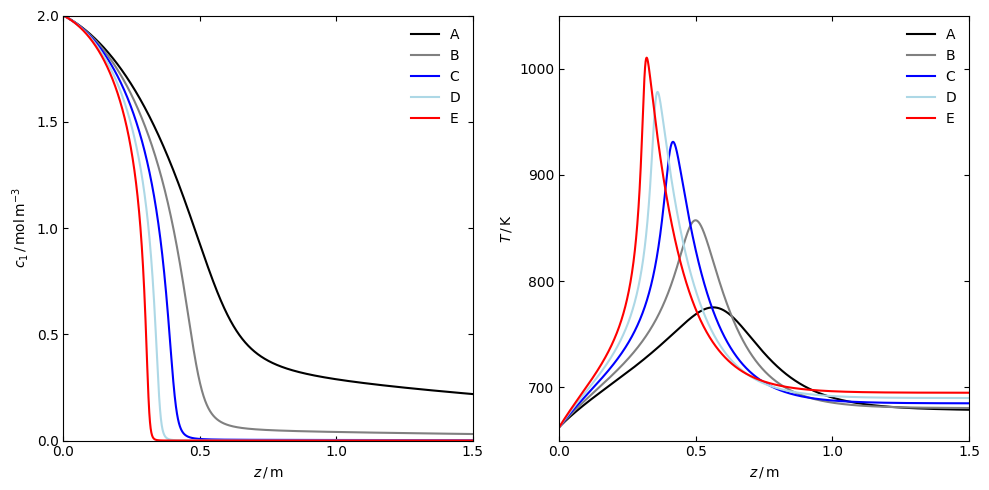

In [9]:
# Beschriftungen und Farben für Plot
lab = ['A', 'B', 'C', 'D', 'E']
col = ['k', 'grey', 'blue', 'lightblue', 'red']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

for sol, ll, cc in zip(res, lab, col):
    # Ergebnisse
    xi      = sol.t         # dimensionslose Ortskoordinate
    f_1     = sol.y[0]      # Restanteil A1
    theta   = sol.y[1]      # dimensionslose Reaktortemperatur

    # Umrechnung der dimensionslosen Größen in entsprechende dimensionsbehaftete Größen
    z       = xi * L_R      # Ortskoordinate in m
    c_1     = f_1 * c_1_e   # Konzentration von A1 in mol m3
    T       = theta * T_e   # Reaktortemperatur in K

    ax[0].plot(z, c_1, color = cc, label = ll)
    ax[1].plot(z, T,   color = cc, label = ll)

ax[0].tick_params(axis="y",direction="in", right = True)
ax[0].tick_params(axis="x",direction="in", top = True)
ax[0].set_ylabel(r'$c_1\,/\,\mathrm{mol\,m^{-3}}$')
ax[0].set_xlabel(r'$z \,/\,\mathrm{m}$')
ax[0].set_xlim(0,1.5)
ax[0].set_ylim(0,2.)
ax[0].set_xticks(np.arange(0, 1.51, step = 0.5))
ax[0].set_yticks(np.arange(0, 2.1, step = 0.5))
ax[0].legend(frameon = False)

ax[1].tick_params(axis="y",direction="in", right = True)
ax[1].tick_params(axis="x",direction="in", top = True)
ax[1].set_ylabel(r'$T\,/\,\mathrm{K}$')
ax[1].set_xlabel(r'$z \,/\,\mathrm{m}$')
ax[1].set_xlim(0,1.5)
ax[1].set_ylim(650,1050)
ax[1].set_xticks(np.arange(0, 1.51, step = 0.5))
ax[1].set_yticks(np.arange(700, 1001, step = 100))
ax[1].legend(frameon = False)

plt.tight_layout()
plt.show()

In obigen Abbildungen ist zu sehen, dass die Temperatur des hot-spots deutlich von der Kühlmitteltemperatur abhängt. 
Folgend soll die Sensitivität des Systems bzgl. der Kühlmitteltemperatur mit Hilfe des Barkelew-Kriteriums (Gleichung 11.8b) abgeschätzt werden.

\begin{align*}
\left( \frac{N}{S}\right)_\mathrm{min} &= \exp(1) - \frac{b}{\sqrt{S}}\\
S &= \beta_\mathrm{K} \, \gamma_\mathrm{K} \\
N &= \frac{St}{Da_\mathrm{I}}
\end{align*}

Zunächst werden $S$ und $N$ bestimmt. Für die Berechnung der Prater-Zahl $\beta_\mathrm{e}$ und der Arrhenius-Zahl $\gamma_\mathrm{K}$ wird angenommen, dass die Kühlmitteltemperatur der Temperatur am Reaktoreingang entspricht $\left( T_\mathrm{e} = T_\mathrm{K} \right)$. Dementsprechend ändern sich auch die Reaktionsgeschwindigkeit $r_\mathrm{K}$ und die Damköhler-Zahl $Da_\mathrm{I,K}$ mit der Kühlmitteltemperatur.

\begin{align*}
\beta_\mathrm{K} &= \frac{\Delta T_\mathrm{ad}}{T_\mathrm{K}}\\
\gamma_\mathrm{K} &= \frac{E_\mathrm{A}}{R\,T_\mathrm{K}}\\
r_\mathrm{K} &= k_0 \exp{(-\gamma_\mathrm{K})} \, c_{1,\mathrm{e}}\\
Da_\mathrm{I,K} &= \frac{\overline{\tau}\,r_\mathrm{K}}{c_{1,\mathrm{e}}}\\
\end{align*}

Die Berechnung der Größen ist wie folgt implementiert.

In [10]:
beta_K      = D_T_ad / T_K                      # Prater-Zahlen
gamma_K     = E_A / R / T_K                     # Arrhenius - Zahlen
r_K         = k_0 * np.exp(-gamma_K) * c_1_e    # dimensionslose Reaktionsgeschwindigkeit
Da_K        = tau * r_K / c_1_e                 # Damköhler-Zahl

# Berechnung von N in 1
N           = St / Da_K

# Berechnung von S in 1
S           = beta_K * gamma_K

# N/S in 1
N_S         = N / S      

# Maximale Temperaturen je Kühltemperatur
T_max = [] # Liste zum Speichern der max Temperaturen
for sol in res:
    theta   = sol.y[1]      # dimensionslose Reaktortemperaturen
    T       = theta * T_e   # Reaktortemperaturen in K
    T_m     = max(T)        # finden der maximalen Temperatur
    T_max.append(T_m)

T_max = np.array((T_max))   # Liste zu Array

Die Ergebnisse werden tabellarisch ausgegeben. Die geringfügigen Abweichungen in der dritten Stelle bei vereinzelten Ergerbnissen sind numerisch bedingt.

In [11]:
# Ausgabe der Ergebnisse als Tabelle

header   = np.array(('Nr.', 'A', 'B', 'C', 'D', 'E'))
names_y  = np.array((['T_K / K'], ['T_max / K'], ['N / 1'], ['S / 1'], ['N/S / 1']))

# Array for table
table = np.hstack((names_y,np.vstack((T_K, np.round(T_max,0) , np.round(N,1), np.round(S,1), np.round(N_S,2)))))

print(tabulate(table, headers = header, numalign="right"))

Nr.           A     B     C     D     E
---------  ----  ----  ----  ----  ----
T_K / K     675   680   685   690   695
T_max / K   775   857   931   978  1010
N / 1      17.5  15.4  13.5  11.9  10.5
S / 1      13.2    13  12.8  12.6  12.5
N/S / 1    1.33  1.18  1.05  0.94  0.84
